In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import os
import cv2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
!pip install pydicom
import pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.7 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_labels = pd.read_csv('/content/drive/MyDrive/Pneumonia Classification/stage_2_train_labels.csv')

In [6]:
train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [7]:
cleaned_train_labels = train_labels.drop_duplicates("patientId")

In [8]:
cleaned_train_labels = cleaned_train_labels.drop(columns=['x','y','width','height'])

In [9]:
print(cleaned_train_labels)

                                  patientId  Target
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6       0
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd       0
2      00322d4d-1c29-4943-afc9-b6754be640eb       0
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5       0
4      00436515-870c-4b36-a041-de91049b9ab4       1
...                                     ...     ...
30219  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2       1
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8       1
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba       0
30224  c1f6b555-2eb1-4231-98f6-50a963976431       0
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a       1

[26684 rows x 2 columns]


In [10]:
ORIGINAL_PATH = '/content/drive/MyDrive/Pneumonia Classification/stage_2_train_images'
PROCESS_PATH = '/content/drive/MyDrive/Pneumonia Classification/stage_2_train_images_processed'

In [11]:
i=0
for patientId in cleaned_train_labels['patientId']:
  image_path = os.path.join(ORIGINAL_PATH,patientId+'.dcm')
  image = pydicom.read_file(image_path)
  image = image.pixel_array/255
  resized_image = cv2.resize(image,(224,224)).astype(np.float16)

  label = str(cleaned_train_labels[cleaned_train_labels['patientId']==patientId]['Target'].values[0])

  train_or_val = 'train' if i<24000 else 'val'

  processed_path = os.path.join(PROCESS_PATH,train_or_val+'/'+label+'/'+patientId)
  os.makedirs(os.path.dirname(processed_path),exist_ok=True)

  np.save(processed_path,resized_image)

  i = i+1



In [25]:
def image_loader(path):
  return np.load(path).astype(np.float32)

In [26]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=0.49,std=0.248),
                                      transforms.RandomRotation(degrees=(-5,5)),
                                      transforms.RandomHorizontalFlip(p=0.5)
                                      ])
val_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor()])

In [27]:
train_dataset = datasets.DatasetFolder('/content/drive/MyDrive/Pneumonia Classification/stage_2_train_images_processed/train',
                                       loader=image_loader,
                                       extensions='npy',
                                       transform=train_transform)
val_dataset = datasets.DatasetFolder('/content/drive/MyDrive/Pneumonia Classification/stage_2_train_images_processed/val',
                                     loader=image_loader,
                                     extensions='npy',
                                     transform=val_transform)
#test_dataset = datasets.DatasetFolder('/content/drive/MyDrive/Pneumonia Classification/stage_2_test_images',loader=image_loader)

In [15]:
len(val_dataset)

2684

In [16]:
np.unique(train_dataset.targets)

array([0, 1])

In [17]:
np.unique(val_dataset.targets)

array([0, 1])

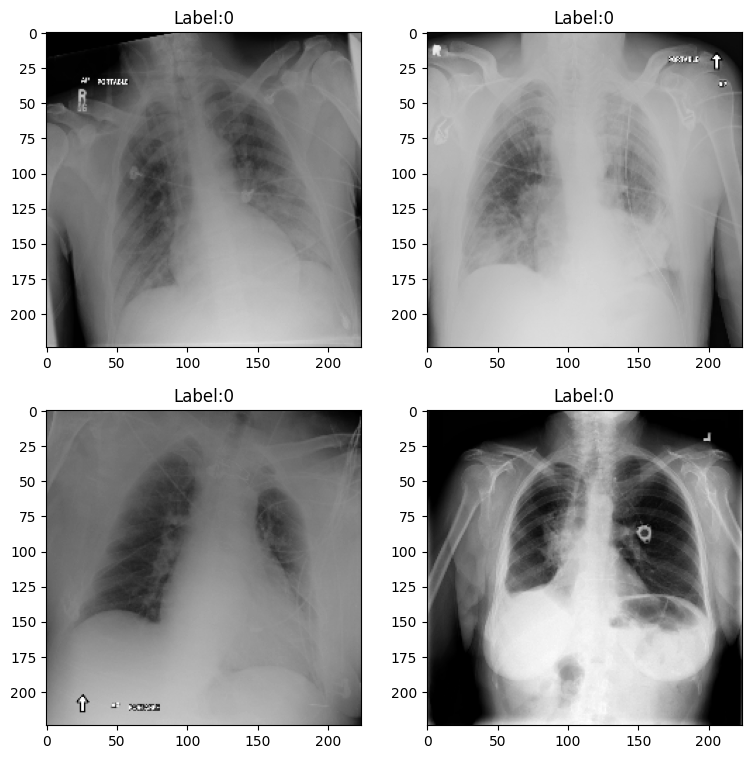

In [28]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        img_path, label = train_dataset.samples[random_index]
        x_ray = np.load(img_path)
        axis[i][j].imshow(x_ray, cmap="gray")
        axis[i][j].set_title(f"Label:{label}")


In [29]:
batch_size = 64
workers = 2
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=workers)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=workers)


In [39]:
class PneumoniaModel(nn.Module):
  def __init__(self):
    super(PneumoniaModel,self).__init__()
    self.model = torchvision.models.resnet18(pretrained=True)
    self.model.conv1 = nn.Conv2d(1,64,kernel_size=(7,7),stride=(2,2),padding=(3,3),bias=False)
    self.model.fc = nn.Linear(512,2)

  def forward(self,x):
    x = self.model(x)
    return x




In [58]:
model = PneumoniaModel()
model = model.to('cuda')
optimizer = optim.Adam(model.parameters(),lr=1e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 10

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to('cuda')
    labels = labels.to('cuda')
    outputs = model(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    predictions = torch.argmax(outputs,axis=1)
    total += labels.size(0)
    correct += (predictions == labels).sum().item()

    if batch_idx % 100 == 0:
      print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

  accuracy = correct / total
  print(f'Epoch: {epoch}, Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 0.7667
Epoch: 0, Batch: 100, Loss: 0.4432
Epoch: 0, Batch: 200, Loss: 0.3554
Epoch: 0, Batch: 300, Loss: 0.4826
Epoch: 0, Training Loss: 0.4139, Accuracy: 0.8074
Epoch: 1, Batch: 0, Loss: 0.4332
Epoch: 1, Batch: 100, Loss: 0.2992
Epoch: 1, Batch: 200, Loss: 0.3407
Epoch: 1, Batch: 300, Loss: 0.3434
Epoch: 1, Training Loss: 0.3778, Accuracy: 0.8281
Epoch: 2, Batch: 0, Loss: 0.3749
Epoch: 2, Batch: 100, Loss: 0.4296
Epoch: 2, Batch: 200, Loss: 0.4227
Epoch: 2, Batch: 300, Loss: 0.4155
Epoch: 2, Training Loss: 0.3626, Accuracy: 0.8347
Epoch: 3, Batch: 0, Loss: 0.3053
Epoch: 3, Batch: 100, Loss: 0.3336
Epoch: 3, Batch: 200, Loss: 0.2938
Epoch: 3, Batch: 300, Loss: 0.3929
Epoch: 3, Training Loss: 0.3493, Accuracy: 0.8426
Epoch: 4, Batch: 0, Loss: 0.4240
Epoch: 4, Batch: 100, Loss: 0.3641
Epoch: 4, Batch: 200, Loss: 0.3035
Epoch: 4, Batch: 300, Loss: 0.3849
Epoch: 4, Training Loss: 0.3391, Accuracy: 0.8481
Epoch: 5, Batch: 0, Loss: 0.3468
Epoch: 5, Batch: 100, Loss:

In [59]:

for epoch in range(11,21):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to('cuda')
    labels = labels.to('cuda')
    outputs = model(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    predictions = torch.argmax(outputs,axis=1)
    total += labels.size(0)
    correct += (predictions == labels).sum().item()

    if batch_idx % 100 == 0:
      print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

  accuracy = correct / total
  print(f'Epoch: {epoch}, Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}')

Epoch: 11, Batch: 0, Loss: 0.2130
Epoch: 11, Batch: 100, Loss: 0.1764
Epoch: 11, Batch: 200, Loss: 0.2453
Epoch: 11, Batch: 300, Loss: 0.2583
Epoch: 11, Training Loss: 0.2248, Accuracy: 0.9048
Epoch: 12, Batch: 0, Loss: 0.2604
Epoch: 12, Batch: 100, Loss: 0.2884
Epoch: 12, Batch: 200, Loss: 0.2097
Epoch: 12, Batch: 300, Loss: 0.1779
Epoch: 12, Training Loss: 0.2043, Accuracy: 0.9152
Epoch: 13, Batch: 0, Loss: 0.1548
Epoch: 13, Batch: 100, Loss: 0.2278
Epoch: 13, Batch: 200, Loss: 0.2776
Epoch: 13, Batch: 300, Loss: 0.1605
Epoch: 13, Training Loss: 0.1808, Accuracy: 0.9253
Epoch: 14, Batch: 0, Loss: 0.0825
Epoch: 14, Batch: 100, Loss: 0.1308
Epoch: 14, Batch: 200, Loss: 0.0858
Epoch: 14, Batch: 300, Loss: 0.1445
Epoch: 14, Training Loss: 0.1483, Accuracy: 0.9407
Epoch: 15, Batch: 0, Loss: 0.0836
Epoch: 15, Batch: 100, Loss: 0.1942
Epoch: 15, Batch: 200, Loss: 0.1125
Epoch: 15, Batch: 300, Loss: 0.1695
Epoch: 15, Training Loss: 0.1308, Accuracy: 0.9498
Epoch: 16, Batch: 0, Loss: 0.1361
E

In [61]:
model.eval()
val_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for batch_idx, (val_images, val_labels) in enumerate(val_loader):
      val_images = val_images.to('cuda')
      val_labels = val_labels.to('cuda')

      val_outputs = model(val_images)

      val_predictions = torch.argmax(val_outputs, axis=1)
      val_correct += (val_predictions == val_labels).sum().item()
      val_total += val_labels.size(0)

val_accuracy = val_correct / val_total
print(f'Validation Accuracy: {val_accuracy:.4f}')

Validation Accuracy: 0.7802


In [62]:
model2 = PneumoniaModel()
model2 = model2.to('cuda')
optimizer = optim.Adam(model2.parameters(),lr=1e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 15

for epoch in range(num_epochs):
  model2.train()
  running_loss = 0.0
  correct = 0
  total = 0
  for batch_idx, (images, labels) in enumerate(train_loader):
    images = images.to('cuda')
    labels = labels.to('cuda')
    outputs = model2(images)
    loss = criterion(outputs,labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

    predictions = torch.argmax(outputs,axis=1)
    total += labels.size(0)
    correct += (predictions == labels).sum().item()

    if batch_idx % 100 == 0:
      print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')

  accuracy = correct / total
  print(f'Epoch: {epoch}, Training Loss: {running_loss / len(train_loader):.4f}, Accuracy: {accuracy:.4f}')

  model2.eval()
  val_loss = 0.0
  val_correct = 0
  val_total = 0
  with torch.no_grad():
    for batch_idx, (val_images, val_labels) in enumerate(val_loader):
      val_images = val_images.to('cuda')
      val_labels = val_labels.to('cuda')

      val_outputs = model2(val_images)

      val_predictions = torch.argmax(val_outputs, axis=1)
      val_correct += (val_predictions == val_labels).sum().item()
      val_total += val_labels.size(0)

  val_accuracy = val_correct / val_total
  print(f'Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batch: 0, Loss: 0.6595
Epoch: 0, Batch: 100, Loss: 0.4131
Epoch: 0, Batch: 200, Loss: 0.5171
Epoch: 0, Batch: 300, Loss: 0.3466
Epoch: 0, Training Loss: 0.4129, Accuracy: 0.8089
Epoch: 0, Validation Loss: 0.0000, Validation Accuracy: 0.5309
Epoch: 1, Batch: 0, Loss: 0.4350
Epoch: 1, Batch: 100, Loss: 0.5142
Epoch: 1, Batch: 200, Loss: 0.3381
Epoch: 1, Batch: 300, Loss: 0.3026
Epoch: 1, Training Loss: 0.3784, Accuracy: 0.8285
Epoch: 1, Validation Loss: 0.0000, Validation Accuracy: 0.5544
Epoch: 2, Batch: 0, Loss: 0.2885
Epoch: 2, Batch: 100, Loss: 0.3428
Epoch: 2, Batch: 200, Loss: 0.3189
Epoch: 2, Batch: 300, Loss: 0.3535
Epoch: 2, Training Loss: 0.3615, Accuracy: 0.8363
Epoch: 2, Validation Loss: 0.0000, Validation Accuracy: 0.7783
Epoch: 3, Batch: 0, Loss: 0.3604
Epoch: 3, Batch: 100, Loss: 0.3976
Epoch: 3, Batch: 200, Loss: 0.2955
Epoch: 3, Batch: 300, Loss: 0.3339
Epoch: 3, Training Loss: 0.3531, Accuracy: 0.8410
Epoch: 3, Validation Loss: 0.0000, Validation Accuracy: 0.7